# Outer Solar System IRKNGL-simd


## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots
#using IRKGaussLegendre
#using OrdinaryDiffEq
#using BenchmarkTools

In [2]:
PATH_SRC="../../src_simd/"
include(string(PATH_SRC,"IRKGL_SIMD.jl"))
using .IRKGL_SIMD   



## Definition of the N-body problem

In Nbody.jl below, the following functions are defined: NbodyEnergy(u,Gm), NbodyODE!(du,u,Gm,t), and NbodyODE1!(du,u,Gm,t), where

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{2 \times 3\times N}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}
This system of ODEs can be writen in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm)
\end{equation*}




In [3]:
PATH_ODES="../../ODEProblems/"

include(string(PATH_ODES,"Initial16Body.jl"))
include(string(PATH_ODES,"Nbody.jl"))
#include(string(PATH_ODES,"Nbody2nd.jl"))

NbodyODE! (generic function with 2 methods)

##### <a href="#top">Back to the top</a>

## Initial value problem: 16-body problem (main asteroids)


In [4]:
u0, Gm, bodylist = Initial16Body(Float64)
q0=u0[:,:,1]
v0=u0[:,:,2]
dim=length(size(u0))

N = length(Gm)

show(bodylist)
E0=NbodyEnergy(u0,Gm)

["Sun" "Mercury" "Venus" "Mars" "Jupiter" "Saturn" "Uranus" "Neptune" "Pluto" "Ceres" "Pallas" "Vesta" "Iris" "Bamberga" "Earth" "Moon"]

-9.822698256164515e-12

### IRKNGL_simd eta IRKNGL16 integrazioak

In [5]:
t0 = 0.
dt = 500.  # 500.
tF = 1e4  #1e8
#tF=  1e6
tF = 100*dt


m=1
println("dt = $dt, m=$m")

prob = ODEProblem(NbodyODE!, u0, (t0,tF), Gm)

tol=1e-6

# Bertsio adaptatiboa
alg=IRKNGL_simd(s=8, initial_interp=1,dim=3,floatType=Float64, m=m,myoutputs=true,nrmbits=0)
sol1,iters1=solve(prob,alg,dt=dt, adaptive=true);

dt = 500.0, m=1
Failure !!!. Maximum number of iterations.  Step=8466.25 dt=7970.125
Fail


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /home/mikel/.julia/packages/SciMLBase/VKnrY/src/retcodes.jl:360


In [6]:
sol1h2,iters1h2=solve(prob,alg,dt=dt/2, adaptive=true);

Failure !!!. Maximum number of iterations.  Step=7672.6875 dt=4238.625
Fail


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /home/mikel/.julia/packages/SciMLBase/VKnrY/src/retcodes.jl:360


In [7]:
# Bertsio urrats-finkoa
alg=IRKNGL_simd(s=8,initial_interp=1,dim=3,floatType=Float64, m=m,myoutputs=true)
sol2,iters=solve(prob,alg,dt=dt, adaptive=false);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /home/mikel/.julia/packages/SciMLBase/VKnrY/src/retcodes.jl:360


In [8]:
sol2h2,itersh2=solve(prob,alg,dt=dt/2, adaptive=false);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase /home/mikel/.julia/packages/SciMLBase/VKnrY/src/retcodes.jl:360


In [9]:
#sol2h4,iters=solve(prob,alg,dt=dt/4, adaptive=false)


# IRKGL16 (SCML bertsioa)
#sol3=solve(prob, IRKGL16(), dt=dt,  adaptive=false);

### Iterazioak

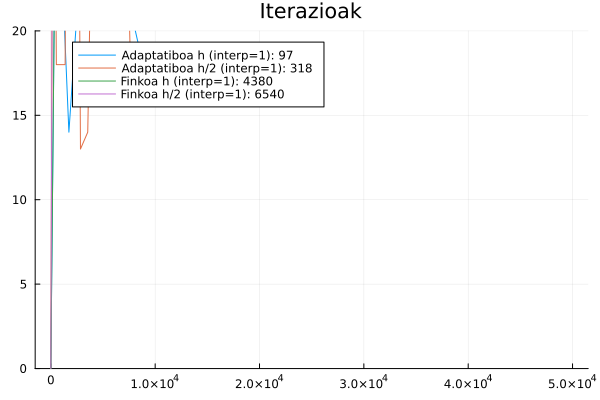

In [10]:
iterfun(iters) = Int64(round(sum(iters)))

p1=plot(title="Iterazioak", ylims=(0,20), legend=:top) #bottom
plot!(sol1.t,iters1,label="Adaptatiboa h (interp=1): $(iterfun(iters1))")
plot!(sol1h2.t,iters1h2,label="Adaptatiboa h/2 (interp=1): $(iterfun(iters1h2))")
plot!(sol2.t,iters,label="Finkoa h (interp=1): $(iterfun(iters))")
plot!(sol2h2.t,itersh2,label="Finkoa h/2 (interp=1): $(iterfun(itersh2))")

### Urrats luzerak

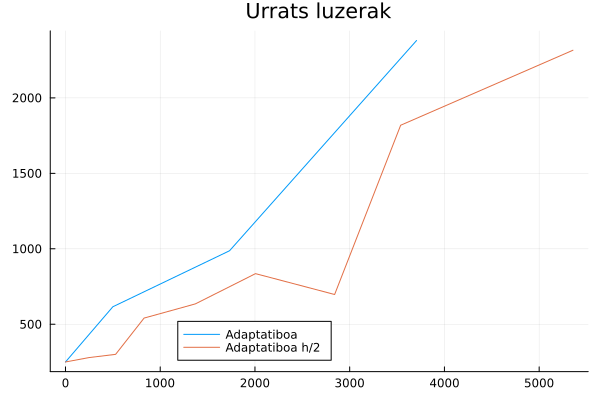

In [11]:
p1=plot(title="Urrats luzerak",  legend=:bottom)
plot!(sol1.t[1:end-1],abs.((sol1.t[2:end].-sol1.t[1:end-1])/2),label="Adaptatiboa")
plot!(sol1h2.t[1:end-1],abs.(sol1h2.t[2:end].-sol1h2.t[1:end-1]),label="Adaptatiboa h/2")

In [12]:
[length(sol1) length(sol2)]

1×2 Matrix{Int64}:
 5  101

In [13]:
[length(sol1h2) length(sol2h2)]

1×2 Matrix{Int64}:
 10  201

In [14]:
#[length(sol1h4) length(sol2h4)]

### Energy erroreak

In [15]:
yrange = (1e-16,1e-4)
year = 365.5

function energy_plot(sol; title="")
    energies = [NbodyEnergy(BigFloat.(u),Gm) for u in sol.u]
    E0 = energies[1]
    epsilon = eps(1e-3)
    errors = Float64.(abs.(energies[2:end]/E0 .- 1)) .+ epsilon
    tt = sol.t[2:end]  #/year
    pl = plot(title=title, ylims=(1e-18,1e-12), 
         yscale=:log10, legend=false) #ylims=yrange, 
    plot!(tt,  errors)
    println(maximum(errors))
    return pl
end

energy_plot (generic function with 1 method)

0.07408544611598461
0.05417302592538009
0.041361013383095696
0.013716360119847216


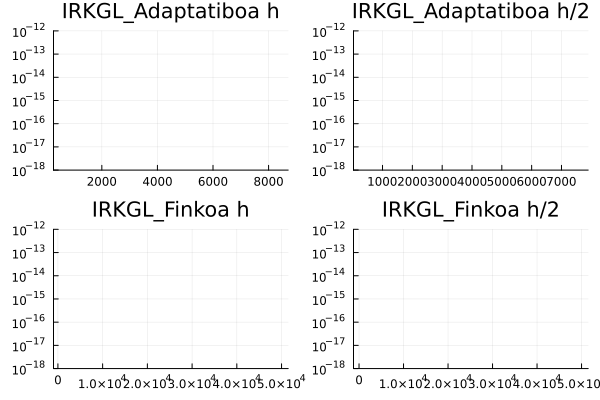

In [16]:
pl1 = energy_plot(sol1,  title="IRKGL_Adaptatiboa h")
pl1h2 = energy_plot(sol1h2, title="IRKGL_Adaptatiboa h/2")

pl2 = energy_plot(sol2, title="IRKGL_Finkoa h")
pl2h2 = energy_plot(sol2h2, title="IRKGL_Finkoa h/2")


plot(pl1, pl1h2,  pl2, pl2h2, layout=(2,2), size=(600,400))


### Kokapenen diferentziak 

u[a,b,c]

   -a:  =1:3  x,y,z;    
   -b:  =1:5  gorputa   
   -c:  =1 kokapenak;   =2 abiadura

In [17]:
norm(sol1.u[1]-sol2.u[1])

0.0

In [18]:
qq1=[u[:,:,1] for u in sol1.u]
qq1h2=[u[:,:,1] for u in sol1h2.u]
qq1h4=[u[:,:,1] for u in sol1h4.u]
qq2=[u[:,:,1] for u in sol2.u]

plot(sol1.t,norm.((qq1-qq2)),seriestype=:scatter, label="qq1-qq2")
#plot!(sol1.t,norm.((qq1-qq1h2)),seriestype=:scatter, label="qq1-qq2h2")
#plot!(sol1.t,norm.((qq1-qq1h4)), seriestype=:scatter, label="qq1-qq2h4")

LoadError: UndefVarError: sol1h4 not defined

In [19]:
norm.((qq1-qq2))./norm.((qq1-qq1h2))

LoadError: UndefVarError: qq2 not defined

In [20]:
norm.((qq1-qq2))./norm.((qq1-qq1h4))

LoadError: UndefVarError: qq2 not defined

In [21]:
b,c,mu,nu,nu1,nu2,gamma=IRKGL_SIMD_adap.IRKGLCoefficients_adap(8,dt);

LoadError: UndefVarError: IRKGL_SIMD_adap not defined

In [22]:
norm(gamma)*norm(inv(gamma))

LoadError: UndefVarError: gamma not defined

In [23]:
gamma*inv(gamma)

LoadError: UndefVarError: gamma not defined